In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('D:/SEMESTER 2/Deep and Gen Ai/Laboratory/pada_freq.csv', header=None, names=['Word_WX', 'Frequency'])

# Normalize the frequency column
scaler = MinMaxScaler()
df['Frequency'] = scaler.fit_transform(df[['Frequency']])

# Convert words to numerical encoding
char_to_index = {char: idx for idx, char in enumerate(sorted(set(''.join(df['Word_WX']))))}

def encode_word(word):
    return [char_to_index[char] for char in word]

df['Encoded_Word'] = df['Word_WX'].apply(encode_word)

In [3]:
# Padding sequences
max_len = max(df['Encoded_Word'].apply(len))
def pad_sequence(seq, max_len):
    return seq + [0] * (max_len - len(seq))

df['Padded_Word'] = df['Encoded_Word'].apply(lambda x: pad_sequence(x, max_len))

# Convert to tensors
X = np.array(df['Padded_Word'].tolist())
y = np.array(df['Frequency'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Define Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the last time step output
        return out

In [5]:
# Model parameters
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1

model = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:

# Training the model
epochs = 50
train_losses = []

y_train_tensor = y_train_tensor.to(device)
X_train_tensor = X_train_tensor.unsqueeze(-1).to(device)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0002
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001


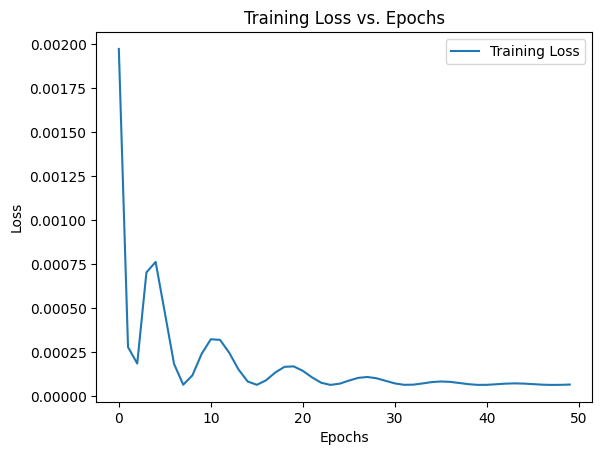

In [7]:
# Plot training loss
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()


In [8]:
# Evaluation
model.eval()
X_test_tensor = X_test_tensor.unsqueeze(-1).to(device)
y_test_tensor = y_test_tensor.to(device)

with torch.no_grad():
    y_pred = model(X_test_tensor)

y_pred = y_pred.cpu().numpy()
y_test = y_test_tensor.cpu().numpy()

# Convert predictions to binary classes based on threshold
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [9]:
# Compute performance metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Windows\System32\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Windows\System32\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Windows\System32\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Windows\System32\myenv\Lib\site-packages\sklearn\metrics\_c

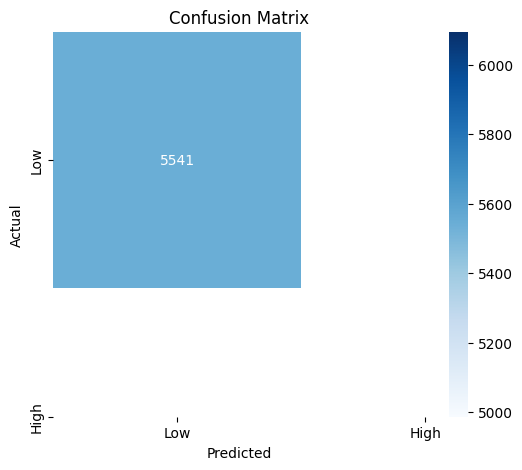

In [10]:
# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()